# Project 3 - API and NLPs

Project showcasing usage of APIs and NLP for text analysis and extracting insights from the same

## Project Title: Sound Decisions - Market Analysis and Consumer Sentiments

## Scenario

We, at JACK’s Consultancy Pte are a leading market research and business intelligence company based in Singapore.
Shure, the world’s leading personal audio and accessories company, is planning to enter the Singapore / South-east Asia market with the launch of their latest new wireless earbuds and headsets.
They’ve reached out to JACK’s and have commissioned to conduct market research and analysis to understand how best to position themselves in the market.

## Problem Statement

1. **Machine Learning**
   - Develop and train a sentiment analysis machine learning model to classify reviews based on their sentiment. 


2. **Data Visualizations and Insights**
    - Create visualizations to represent the findings clearly. 
    - Provide a detailed report with actionable insights and recommendations for the client.

## Index

1. [Initial Setup](#1.-Initial-Setup)
2. [Data Collection and Cleaning](#2.-Data-Collection-and-Cleaning)
3. [Initial Data Analysis](#3.-Initial-Data-Analysis)
4. [Exploratory Data Analysis](#4.-Exploratory-Data-Analysis)
5. [Machine Learning](#5.-Modelling-and-Classification)
6. [Conclusions](#6.-Conclusions-and-Next-Steps)

## 1. Initial Setup

This section contains the initial configuration for the notebook, and includes sections listing out the python libraries needed, as well as additional help files, and helper libraries.

### Import statements

In [1]:
# Standard Python libraries
import pandas as pd
import numpy as np
from collections import Counter

# Python system libraries
import requests
import os
import csv
import seaborn as sns

# Visualization libraries
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Text-processing libraries
import re
import nltk
import fasttext
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Machine learning libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import classification_report, accuracy_score
from scipy.sparse import hstack
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import xgboost as xgb

In [2]:
import warnings
# Ignore all warnings
warnings.filterwarnings('ignore')

### Additional Supporting files

In [3]:
# Download the model using wget
!wget -P datasets https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.ftz

# Load and instantiate fast text binary
model = fasttext.load_model('datasets/lid.176.ftz')


# Regular expression to match emojis
emoji_pattern = re.compile(
    "["u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
    "]+", flags=re.UNICODE)


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

--2024-07-02 16:47:26--  https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.ftz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 2600:9000:2753:6000:13:6e38:acc0:93a1, 2600:9000:2753:fc00:13:6e38:acc0:93a1, 2600:9000:2753:1200:13:6e38:acc0:93a1, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|2600:9000:2753:6000:13:6e38:acc0:93a1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 938013 (916K) [binary/octet-stream]
Saving to: 'datasets/lid.176.ftz.6'

lid.176.ftz.6       100%[===================>] 916.03K  --.-KB/s    in 0.1s    

2024-07-02 16:47:26 (7.61 MB/s) - 'datasets/lid.176.ftz.6' saved [938013/938013]



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/anilgangolli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anilgangolli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/anilgangolli/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Helper functions

In [4]:
# Function to extract country using regex
def extract_country(date_string):
    match = re.search(r'in\s(.*?)\son', date_string)
    if match:
        return match.group(1).strip()
    else:
        return 'Unknown'

# Function to detect language using fastText
def is_english(review_title, review_comment):
    combined_text = (review_title + ' ' + review_comment).replace('\n', ' ') # Combine the text, and replace newline chars
    predictions = model.predict(combined_text)
    return predictions[0][0] == '__label__en'

# Count records with emojis
def has_emoji(text):
    return bool(emoji_pattern.search(text))

# Remove emojis
def remove_emojis(text):
    return emoji_pattern.sub('', text)

# Define the function to categorize ratings
def categorize_rating(rating):
    if rating in [1, 2]:
        return 'low'
    elif rating in [3, 4]:
        return 'average'
    elif rating == 5:
        return 'excellent'
    else:
        return 'unknown'  # Handle unexpected values, if any
    
# Function to preprocess text
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stop words
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join the tokens back into a single string
    text = ' '.join(tokens)
    
    return text


# Function to create a word cloud with a maximum of 20 words
def create_wordcloud(text, title, max_words=20):
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=max_words).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Function to create a bar chart for the top 20 terms
def create_barchart(text, title, max_words=20):
    words = text.split()
    word_freq = Counter(words)
    most_common_words = word_freq.most_common(max_words)
    words, counts = zip(*most_common_words)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(counts), y=list(words), palette='crest')
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('Terms')
    plt.show()
    
    
# Define a function to get n-grams
def get_ngrams(text_data, n):
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words='english')
    ngrams = vectorizer.fit_transform(text_data)
    ngrams_freq = ngrams.sum(axis=0).A1
    vocab = vectorizer.get_feature_names_out()
    ngrams_freq_series = pd.Series(ngrams_freq, index=vocab).sort_values(ascending=False)
    return ngrams_freq_series

# Function to match review to an Aspect
def match_aspect(review, aspects):
    for aspect, keywords in aspects.items():
        if any(re.search(r'\b' + keyword + r'\b', review) for keyword in keywords):
            return aspect
    return 'Other'

# Match reviews to personas based on Aspects
def match_persona(review, personas, aspects):
    review_aspects = [aspect for aspect, keywords in aspects.items() if any(re.search(r'\b' + keyword + r'\b', review) for keyword in keywords)]
    for persona, persona_aspects in personas.items():
        if any(aspect in review_aspects for aspect in persona_aspects):
            return persona
    return 'Other'

## 2. Data Collection and Cleaning

For the project, we narrowed down to and chose to collect reviews of competing audio brands and similar products from Amazon.

To simplify the process of data collection, we chose to use a 3rd party API marketplace - [RapidAPI](rapidapi.com).

We utilized two APIs from this :
- to collect the product Ids (aka ASIN codes) for top-selling models and top-reviewed models for various premium brands e.g. Sony, Sennheiser, Bose etc.
- collate the reviews for the ASIN codes, and capture key information including the Review Title, Review Comment, Star Rating, Time of Review, and Verified Buyer

As RapidAPI is a marketplace and restricts API usage after 100 free attempts, we divided the task, and ran our own codes to fetch the dataset separately.

_Note: I've commented out the Data Collection code blocks below as the keys used may be unusable due to the hard limits set on RapidAPI's end. If fresh API-keys are needed, please reach out to me._



### Data Collection

We used the **_requests_** library to fetch the ASIN codes first.

In [5]:
# url = "https://real-time-amazon-data.p.rapidapi.com/products-by-category"

# headers = {
#     "x-rapidapi-key": "9fd64d986bmshe0bdabfe9604690p145d68jsne48be8607def",
#     "x-rapidapi-host": "real-time-amazon-data.p.rapidapi.com"
# }

# results_bestsellers_sennheiser = []  # List to store the results

# for page in range(1, 6):  # Loop from page 1 to page 5
#     querystring = {
#         "category_id": "6436357051",
#         "page": str(page),  # Convert page number to string
#         "country": "SG",
#         "sort_by": "BEST_SELLERS",
#         "product_condition": "ALL",
#         "brand": "SENNHEISER"
#     }

#     response = requests.get(url, headers=headers, params=querystring)

#     if response.status_code == 200:  # Check if the request was successful
#         results_bestsellers_sennheiser.append(response.json())  # Append the JSON response to the results list
#     else:
#         print(f"Failed to retrieve data for page {page}: {response.status_code}")

Next, we separate out the ASINs into their own list

In [6]:
# asin_values = []

# for page in results_bestsellers_sennheiser:
#     products = page.get('data', {}).get('products', [])
#     for product in products:
#         asin = product.get('asin')
#         if asin:
#             asin_values.append(asin)

# # Print or use the list of ASIN values
# print(asin_values)

Finally, we retrieved the list of reviews for the ASIN code using the reviews API from RapidAPI

In [7]:
# url = "https://real-time-amazon-data.p.rapidapi.com/product-reviews"

# headers = {
#     "x-rapidapi-key": "e2f2c695ccmsh49215ec69454a49p1109c6jsn4707bc0868db",
#     "x-rapidapi-host": "real-time-amazon-data.p.rapidapi.com"
# }

# # List to store the review results for each ASIN
# all_reviews = []

# for asin in asin_values:
#     querystring = {
#         "asin": asin,
#         "country": "SG",
#         "sort_by": "MOST_RECENT",
#         "star_rating": "ALL",
#         "verified_purchases_only": "true",
#         "images_or_videos_only": "false",
#         "current_format_only": "false",
#         "page": "1"
#     }

#     response = requests.get(url, headers=headers, params=querystring)

#     if response.status_code == 200:  # Check if the request was successful
#         reviews = response.json().get('data', {}).get('reviews', [])
#         for review in reviews:
#             all_reviews.append({
#                 'asin': asin,
#                 'review_id': review.get('review_id'),
#                 'review_title': review.get('review_title'),
#                 'review_text': review.get('review_comment'),  # Assuming review_comment is the correct field
#                 'review_rating': review.get('review_star_rating'),
#                 'review_date': review.get('review_date'),
#                 'verified_purchase': review.get('is_verified_purchase'),
#                 'helpful_votes': review.get('helpful_votes', 0)  # Assuming helpful_votes can be 0 if not present
#             })
#     else:
#         print(f"Failed to retrieve reviews for ASIN {asin}: {response.status_code}")

# # Save the all_reviews list to a CSV file
# with open('all_reviews.csv', 'w', newline='', encoding='utf-8') as file:
#     writer = csv.DictWriter(file, fieldnames=[
#         'asin', 'review_id', 'review_title', 'review_text',
#         'review_rating', 'review_date', 'verified_purchase', 'helpful_votes'])
#     writer.writeheader()
#     writer.writerows(all_reviews)

# print("Reviews have been saved to all_reviews.csv")

This process was repeated by all 4 team members, where we obtained a small handful of different files.

We collated all these files (code not included here) into a raw file - _dataset_combined_reviews.csv_

### Data Cleaning

In [8]:
all_reviews = pd.read_csv('datasets/dataset_combined_reviews.csv')
all_reviews.head()

,review_id,review_title,review_comment,review_star_rating,review_link,review_author,review_author_avatar,review_images,review_video,review_date,is_verified_purchase,reviewed_product_asin,helpful_vote_statement,review_video.stream_url,review_video.closed_captions_url,review_video.thumbnail_url
0,R3QVUB9DT90IEE,"Not great - weak audio, mic, cheapo build quality",You'll get what you pay for (or maybe even les...,2,NaN,NaN,NaN,NaN,NaN,Reviewed in Singapore on 11 September 2023,True,B084X7Y51M,0,NaN,NaN,NaN
1,R1117V2OVYF9VG,Balanced sound,Well balanced sound and reasonable built quali...,5,NaN,NaN,NaN,NaN,NaN,Reviewed in Singapore on 8 April 2023,True,B084X7Y51M,0,NaN,NaN,NaN
2,R10KG90XG89P1D,Quality ear piece at reasonable price.,Goods arrived the next day after order. Good q...,4,NaN,NaN,NaN,NaN,NaN,Reviewed in Singapore on 24 March 2022,True,B084X7Y51M,0,NaN,NaN,NaN
3,R26KVL9NHSY4WJ,el sonido,"no son muy buenos, la verdad, están bien porqu...",3,NaN,NaN,NaN,NaN,NaN,Reviewed in Spain on 11 June 2024,True,B084X7Y51M,0,NaN,NaN,NaN
4,RH1H14WGFEEWH,Great cheap earbuds,Exactly what you expect from this company and ...,5,NaN,NaN,NaN,NaN,NaN,Reviewed in the United States on 1 June 2024,True,B084X7Y51M,0,NaN,NaN,NaN


In [9]:
all_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5942 entries, 0 to 5941
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   review_id                         5942 non-null   object 
 1   review_title                      5942 non-null   object 
 2   review_comment                    5927 non-null   object 
 3   review_star_rating                5942 non-null   int64  
 4   review_link                       4864 non-null   object 
 5   review_author                     4862 non-null   object 
 6   review_author_avatar              4864 non-null   object 
 7   review_images                     4864 non-null   object 
 8   review_video                      0 non-null      float64
 9   review_date                       5942 non-null   object 
 10  is_verified_purchase              5942 non-null   bool   
 11  reviewed_product_asin             5942 non-null   object 
 12  helpfu

We have 16 columns, and a few of them include data such as personal identifiable information, and others have additional metadata which we do not need. 
We'll drop these straightaway.

In [10]:
columns_to_drop = [
    'review_link', 'review_author','review_author_avatar', 'review_images', 'review_video',
    'review_video.stream_url','review_video.closed_captions_url', 'review_video.thumbnail_url'
]

all_reviews_cleaned = all_reviews.drop(columns=columns_to_drop)

In [11]:
all_reviews_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5942 entries, 0 to 5941
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_id               5942 non-null   object
 1   review_title            5942 non-null   object
 2   review_comment          5927 non-null   object
 3   review_star_rating      5942 non-null   int64 
 4   review_date             5942 non-null   object
 5   is_verified_purchase    5942 non-null   bool  
 6   reviewed_product_asin   5942 non-null   object
 7   helpful_vote_statement  2904 non-null   object
dtypes: bool(1), int64(1), object(6)
memory usage: 330.9+ KB


This is a good overview to start with - the dataset has about 5.9K entries, with only 2 columns (_review_comment_ and _helpful_vote_statement_) showing empty rows.

This is expected, as the review fields on Amazon typically require star ratings, and review titles, but not review comments to be filled out.

Let's take a look at a sample of the cleaned dataset to understand the contents, and plan for further processing.

In [12]:
all_reviews_cleaned.sample(5)

,review_id,review_title,review_comment,review_star_rating,review_date,is_verified_purchase,reviewed_product_asin,helpful_vote_statement
912,R12GMFS8ZA1RJY,2連続不良品,前買ったゼンハイザーのイヤホンは左が全く聞こえなくて不良品でした。\n今回のこの商品は充電コ...,1,Reviewed in Japan on 22 April 2024,True,B09GJXNFD3,0
3104,R3TWACCT3NHHRU,Tantos puntos positivos como negativos.,Comprados en oferta a un precio por el que es ...,3,Reviewed in Spain on 6 August 2021,True,B07HGJJ7GB,NaN
4334,R2EGO9S394M42,I returned them,cheap,3,Reviewed in the United States on 24 May 2024,True,B08WM3LMJF,NaN
3603,R4H4SMLREVCQV,El material no el mismo,He usado durante los últimos años estos auricu...,3,Reviewed in Spain on 25 April 2024,True,B01MG62Z5M,One person found this helpful
4922,R3MDC57WW6CEN0,On ear,I liked the price 30.00.\nI didn't notice it w...,3,Reviewed in the United States on 6 May 2024,True,B08WM3LMJF,NaN


The review_date column is interesting, as it contains both the country and a review date.

We'll add 2 more columns, breaking out country and year into their own columns.

Finally we'll drop the review_date column as well.

##### Extracting the year into review_year

In [13]:
# Extract just the year from review_date and create a new column review_year
all_reviews_cleaned['review_year'] = pd.to_datetime(all_reviews_cleaned['review_date'].str.extract('(\d+ \w+ \d+)')[0]).dt.year

# Printing out the first few records to check
print(all_reviews_cleaned[['review_id', 'review_year']].head())

# Get a count of reviews by year
reviews_by_year = all_reviews_cleaned['review_year'].value_counts().sort_index()
print("\nReviews by year:")
print(reviews_by_year)

        review_id  review_year
0  R3QVUB9DT90IEE         2023
1  R1117V2OVYF9VG         2023
2  R10KG90XG89P1D         2022
3  R26KVL9NHSY4WJ         2024
4   RH1H14WGFEEWH         2024

Reviews by year:
2012       1
2013       9
2014      12
2015      19
2016       9
2017      17
2018      55
2019     137
2020     320
2021     353
2022     498
2023    1254
2024    3258
Name: review_year, dtype: int64


##### Extracting the country name into review_country

In [14]:
# Using helper function extract_country() to extract the country name
all_reviews_cleaned['review_country'] = all_reviews_cleaned['review_date'].apply(extract_country)

# Display the first few rows to verify the new column
print(all_reviews_cleaned[['review_id', 'review_year', 'review_country']].head())

# Get a count of reviews by country
reviews_by_country = all_reviews_cleaned['review_country'].value_counts()
print("\nReviews by country:")
print(reviews_by_country)

        review_id  review_year     review_country
0  R3QVUB9DT90IEE         2023          Singapore
1  R1117V2OVYF9VG         2023          Singapore
2  R10KG90XG89P1D         2022          Singapore
3  R26KVL9NHSY4WJ         2024              Spain
4   RH1H14WGFEEWH         2024  the United States

Reviews by country:
the United States     2001
Canada                 515
Germany                485
Mexico                 391
Italy                  387
Singapore              378
Brazil                 301
Spain                  264
France                 243
the United Kingdom     214
Japan                  208
India                  207
Australia              170
Belgium                 59
the Netherlands         53
Poland                  34
Sweden                  32
Name: review_country, dtype: int64


##### Dropping the review_date column completely

In [15]:
all_reviews_cleaned = all_reviews_cleaned.drop('review_date', axis=1)
all_reviews_cleaned.sample(5)

,review_id,review_title,review_comment,review_star_rating,is_verified_purchase,reviewed_product_asin,helpful_vote_statement,review_year,review_country
5891,R1IEMYY90DCVWV,Not worth the money,The active noise canceling isn’t even as good ...,1,True,B0BVBVPSX6,2 people found this helpful,2023,the United States
4850,R2QULHIX20FW3G,Not sure how long this item last!,Only use about 1 hour a day for 4-5 months and...,1,True,B08WM3LMJF,NaN,2024,the United States
2309,R2LJUYJMWX5FZ0,Not that comfortable,"They sound great, but they aren't very comfort...",3,True,B08WM298TV,NaN,2024,the United States
4859,R2TJUN6ZBV43OB,Cheap quality,Can’t talk on cell with these. Too much backgr...,1,True,B08WM3LMJF,NaN,2024,the United States
4043,R2PHBITJB9CJTA,Ótima qualidade de som,Fone com ótima qualidade de som e muito confor...,5,True,B08WM298TV,NaN,2023,Brazil


Next, we'll focus on the helpful_vote_statement column - if we see this being inconsistent, we'll drop it.

##### Analysis on _helpful_vote_statement_ column

In [16]:
# 1. Getting basic info
print(all_reviews_cleaned['helpful_vote_statement'].info())

# 2. Printing unique values and their counts
unique_values = all_reviews_cleaned['helpful_vote_statement'].value_counts(dropna=False)
print("\nUnique values and their counts:")
print(unique_values)

<class 'pandas.core.series.Series'>
RangeIndex: 5942 entries, 0 to 5941
Series name: helpful_vote_statement
Non-Null Count  Dtype 
--------------  ----- 
2904 non-null   object
dtypes: object(1)
memory usage: 46.5+ KB
None

Unique values and their counts:
NaN                              3038
0                                1078
One person found this helpful     793
2 people found this helpful       298
3 people found this helpful       141
                                 ... 
468 people found this helpful       1
39 people found this helpful        1
47 people found this helpful        1
237 people found this helpful       1
208 people found this helpful       1
Name: helpful_vote_statement, Length: 79, dtype: int64


In [17]:
# 3. Dropping helpful_vote_statement
all_reviews_cleaned = all_reviews_cleaned.drop('helpful_vote_statement', axis=1)
all_reviews_cleaned.sample(5)

,review_id,review_title,review_comment,review_star_rating,is_verified_purchase,reviewed_product_asin,review_year,review_country
2684,R3588SRD06QZVC,Un poco decepcionantes,"Me esperaba más de JBL. Dinámica plana, como s...",3,True,B01MG62Z5M,2023,Spain
752,R271KVFRB1XD81,They don't work properly.,"I think the pair I received is faulty, the vol...",1,True,B0765RF78D,2023,the United States
4393,R3FB5CQ6O8NM4K,"Good audio quality, long battery, light weight",Bought this for my teenager. Ended up buying m...,5,True,B08WM3LMJF,2023,Singapore
5508,R33G2SDJUBJJSZ,Parfait,Fonctionne parfaitement. Excellent réduction d...,5,True,B0BVBVPSX6,2023,Canada
2585,R28T5HP72QQ9MD,Maivaise qualité,Très déçu de cet achat surtout pour du jbl.\nJ...,1,True,B01MG62Z5M,2023,France


Last column to check - _is_verified_purchase_

In [18]:
print(all_reviews_cleaned['is_verified_purchase'].info())

# 2. Printing unique values and their counts
value_counts = all_reviews_cleaned['is_verified_purchase'].value_counts(dropna=False)
print("Value counts:")
print(value_counts)

<class 'pandas.core.series.Series'>
RangeIndex: 5942 entries, 0 to 5941
Series name: is_verified_purchase
Non-Null Count  Dtype
--------------  -----
5942 non-null   bool 
dtypes: bool(1)
memory usage: 5.9 KB
None
Value counts:
True     5934
False       8
Name: is_verified_purchase, dtype: int64


In [19]:
# Dropping is_verified_purchase
all_reviews_cleaned = all_reviews_cleaned.drop('is_verified_purchase', axis=1)
all_reviews_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5942 entries, 0 to 5941
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   review_id              5942 non-null   object
 1   review_title           5942 non-null   object
 2   review_comment         5927 non-null   object
 3   review_star_rating     5942 non-null   int64 
 4   reviewed_product_asin  5942 non-null   object
 5   review_year            5942 non-null   int64 
 6   review_country         5942 non-null   object
dtypes: int64(2), object(5)
memory usage: 325.1+ KB


Next, as only review_comment has a few empty values, we'll replace those with an empty string.

In [20]:
all_reviews_cleaned['review_comment'] = all_reviews_cleaned['review_comment'].fillna('')
all_reviews_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5942 entries, 0 to 5941
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   review_id              5942 non-null   object
 1   review_title           5942 non-null   object
 2   review_comment         5942 non-null   object
 3   review_star_rating     5942 non-null   int64 
 4   reviewed_product_asin  5942 non-null   object
 5   review_year            5942 non-null   int64 
 6   review_country         5942 non-null   object
dtypes: int64(2), object(5)
memory usage: 325.1+ KB


Now from the few sample reviews above, and the country column, we've already identified that there are some reviews in languages other than English.
For the purposes of this exercise, we'll stick to using only English reviews for now.

##### Identifying and removing non-English reviews

To identify and label the languages for the reviews, we will use the **fasttext** library.

We will use this within a helper function, to identify if the text in the review_title or review_comment fields are in English or not.

In [21]:
# Apply language detection to filter English reviews with helper function is_english()
all_reviews_cleaned['is_english'] = all_reviews_cleaned.apply(lambda row: is_english(row['review_title'], row['review_comment']), axis=1)
all_reviews_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5942 entries, 0 to 5941
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   review_id              5942 non-null   object
 1   review_title           5942 non-null   object
 2   review_comment         5942 non-null   object
 3   review_star_rating     5942 non-null   int64 
 4   reviewed_product_asin  5942 non-null   object
 5   review_year            5942 non-null   int64 
 6   review_country         5942 non-null   object
 7   is_english             5942 non-null   bool  
dtypes: bool(1), int64(2), object(5)
memory usage: 330.9+ KB


In [22]:
all_reviews_cleaned.sample(5)

,review_id,review_title,review_comment,review_star_rating,reviewed_product_asin,review_year,review_country,is_english
4305,R20VBAREMCM5R8,• THE GOOD WITH THE BAD,They won’t blow your mind with quality but you...,3,B08WM3LMJF,2024,the United States,True
1598,R3NHYO1IVNLXTG,Una pasada,Ideal para salir a correr,5,B09LT2R5XK,2022,Spain,False
2616,RCJVLCM0O9579,Ja aber nein...,"Günstiger Preis, ganz vernünftiger Sound, schl...",3,B01MG62Z5M,2024,Germany,False
1344,R1FRZS0GXTFFLT,Great headphones only for exercise,I use these for outdoor morning exercises and ...,4,B09BVYBS4J,2024,India,True
799,R3FZLBX3DOJ6OL,My all-time favorite headphones ... until they...,For some initial context: I've now owned three...,3,B07WWKH1B7,2023,the United States,True


In [23]:
# Filter out non-English reviews
all_reviews_cleaned_english = all_reviews_cleaned[all_reviews_cleaned['is_english']]
all_reviews_cleaned_english = all_reviews_cleaned_english.drop(columns=['is_english']) # Drop the helper column
all_reviews_cleaned_english.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3508 entries, 0 to 5941
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   review_id              3508 non-null   object
 1   review_title           3508 non-null   object
 2   review_comment         3508 non-null   object
 3   review_star_rating     3508 non-null   int64 
 4   reviewed_product_asin  3508 non-null   object
 5   review_year            3508 non-null   int64 
 6   review_country         3508 non-null   object
dtypes: int64(2), object(5)
memory usage: 219.2+ KB


That's a drop from 5.9K to 3.5K records. Finally, we'll drop duplicates to complete the initial data cleaning

##### Dropping duplicates

In [24]:
# Get the count of duplicate rows using the review_id column to check
duplicate_count = all_reviews_cleaned_english['review_id'].duplicated().sum()
print(f"Number of duplicate reviews based on review_id: {duplicate_count}")

Number of duplicate reviews based on review_id: 1789


In [25]:
# Drop the duplicate rows
all_reviews_english_unique = all_reviews_cleaned_english.drop_duplicates(subset=['review_id'], keep='first')
all_reviews_english_unique.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1719 entries, 0 to 5564
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   review_id              1719 non-null   object
 1   review_title           1719 non-null   object
 2   review_comment         1719 non-null   object
 3   review_star_rating     1719 non-null   int64 
 4   reviewed_product_asin  1719 non-null   object
 5   review_year            1719 non-null   int64 
 6   review_country         1719 non-null   object
dtypes: int64(2), object(5)
memory usage: 107.4+ KB


In [26]:
# Print out a sample from the unique reviews dataset
all_reviews_english_unique.sample(5)

,review_id,review_title,review_comment,review_star_rating,reviewed_product_asin,review_year,review_country
2377,R1H0RQJUQRUZ0C,"Good sound, ear fatigue","Not very comfortable, but the sound is good. I...",3,B08WM1V5P1,2024,the United States
2052,R24C5U5L3DL6C2,"Excellent product, but frustrating pre-order e...",Overall: Excellent noise cancellation and soun...,1,B0C33XXS56,2023,India
525,RP1ICPA3E6V5I,Five Stars,Excellent item,5,B004CQNTF6,2014,the United States
2106,R2WP9HVYDO7TT5,I've owned 3 of these,Two opencomm 2 uc and One opencomm 2. All have...,3,B0C88R9FHG,2024,the United States
1767,R1VIR0A484FFOU,Not that great of a product - quality of sound...,I recently found out that I have contact derma...,2,B0B7QKT986,2024,the United States


After dropping duplicate records, we're left with a bit less than one-third of the original dataset.

One last check - as NLP is best done on classic text, and reviews may have emojis within, we should check and clear emojis from the review title and comment columns.

##### Emoji check

In [27]:
# Get the count of records with emojis with helper function has_emoji
all_reviews_english_unique['has_emoji'] = all_reviews_english_unique.apply(lambda row: has_emoji(row['review_title']) or has_emoji(row['review_comment']), axis=1) 
count_emojis = all_reviews_english_unique['has_emoji'].sum()
print(f"Number of records with emojis: {count_emojis}")

Number of records with emojis: 31


As there are 31 records with emojis, we'll keep them, but just replace the emojis themselves with empty strings

In [28]:
# Replace emojis with empty string using helper function remove_emojis()
all_reviews_english_unique['review_title'] = all_reviews_english_unique['review_title'].apply(remove_emojis)
all_reviews_english_unique['review_comment'] = all_reviews_english_unique['review_comment'].apply(remove_emojis)

In [29]:
# Drop helper column has_emoji
all_reviews_english_unique = all_reviews_english_unique.drop('has_emoji', axis=1)

In [30]:
all_reviews_english_unique.sample(5)

,review_id,review_title,review_comment,review_star_rating,reviewed_product_asin,review_year,review_country
1226,RQ9B8NBYBW91B,Excellent quality,"Excellent quality, good price an on time deliv...",5,B08K972R42,2023,the United States
58,R2VKOB8MAQ19RL,Right earbud dead after 5 months.,No way of contacting customer support. Horribl...,1,B09T935X38,2024,Singapore
157,R19YO0SQJZPMQA,MOST FRUSTRATING CONTROL BUTTONS IMAGINABLE,Audio quality on these earbuds is pretty good....,2,B08DCLRYWB,2021,Singapore
2243,R18XHRK7RTBGX7,Left earbud stops working all the time and doe...,Sound is ok. Left ear bud only worked for one...,1,B07HS1V2QK,2020,Canada
2220,R2S2A2T2DN99AU,Disconnects constantly,When I first purchased this I thought maybe I ...,1,B07T866P98,2023,the United States


In [31]:
all_reviews_english_unique.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1719 entries, 0 to 5564
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   review_id              1719 non-null   object
 1   review_title           1719 non-null   object
 2   review_comment         1719 non-null   object
 3   review_star_rating     1719 non-null   int64 
 4   reviewed_product_asin  1719 non-null   object
 5   review_year            1719 non-null   int64 
 6   review_country         1719 non-null   object
dtypes: int64(2), object(5)
memory usage: 107.4+ KB


In [32]:
file_path = "datasets/all_reviews_english_unique.csv"
all_reviews_english_unique.to_csv(file_path, index=False)
print(f"Updated data has been saved to {file_path}")

Updated data has been saved to datasets/all_reviews_english_unique.csv


To summarize the initial data extraction, we started with 5,942 records at the start, and filtering down using various methods such as deduplication, keeping only English reviews etc, we have a final dataset of 1719 records.

## 3. Initial Data Analysis

For our initial data analysis, let's run through a basic dive into the dataset.

In [33]:
# Assign to a new dataframe ida_df
ida_df = all_reviews_english_unique
ida_df.head()

,review_id,review_title,review_comment,review_star_rating,reviewed_product_asin,review_year,review_country
0,R3QVUB9DT90IEE,"Not great - weak audio, mic, cheapo build quality",You'll get what you pay for (or maybe even les...,2,B084X7Y51M,2023,Singapore
1,R1117V2OVYF9VG,Balanced sound,Well balanced sound and reasonable built quali...,5,B084X7Y51M,2023,Singapore
2,R10KG90XG89P1D,Quality ear piece at reasonable price.,Goods arrived the next day after order. Good q...,4,B084X7Y51M,2022,Singapore
4,RH1H14WGFEEWH,Great cheap earbuds,Exactly what you expect from this company and ...,5,B084X7Y51M,2024,the United States
6,R2FWKXPGXEIZFZ,Suitable for sleeping,The small profile of the earphones make it per...,5,B084X7Y51M,2024,the United States


Checking simple stats - 

In [34]:
ida_df.shape

(1719, 7)

In [35]:
ida_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1719 entries, 0 to 5564
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   review_id              1719 non-null   object
 1   review_title           1719 non-null   object
 2   review_comment         1719 non-null   object
 3   review_star_rating     1719 non-null   int64 
 4   reviewed_product_asin  1719 non-null   object
 5   review_year            1719 non-null   int64 
 6   review_country         1719 non-null   object
dtypes: int64(2), object(5)
memory usage: 107.4+ KB


##### Word count length distributions across reviews

Let's find out the distribution of word counts across all review comments

The longest review is  9251 words long


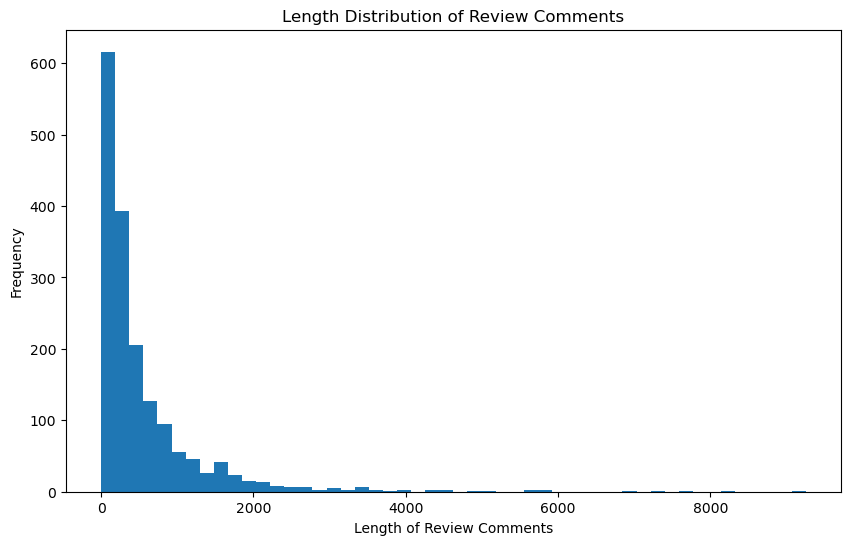

In [36]:
# Calculate the length of review comments
ida_df['comment_length'] = ida_df['review_comment'].apply(lambda x: len(str(x)))

max_words_in_review = ida_df.comment_length.max()
print('The longest review is ', max_words_in_review, 'words long')

# Plot the length distribution
plt.figure(figsize=(10, 6))
ida_df['comment_length'].plot(kind='hist', bins=50, title='Length Distribution of Review Comments') 
plt.xlabel('Length of Review Comments')
plt.ylabel('Frequency')
plt.show()

Most reviews are between 50-100 words, but the longest is over 9.2K words.

##### Distribution of star ratings

Amazon lets users rate products on a star rating with 1 star being the lowest, and 5 being the highest.

Let's find and plot the distribution of these ratings across the reviews

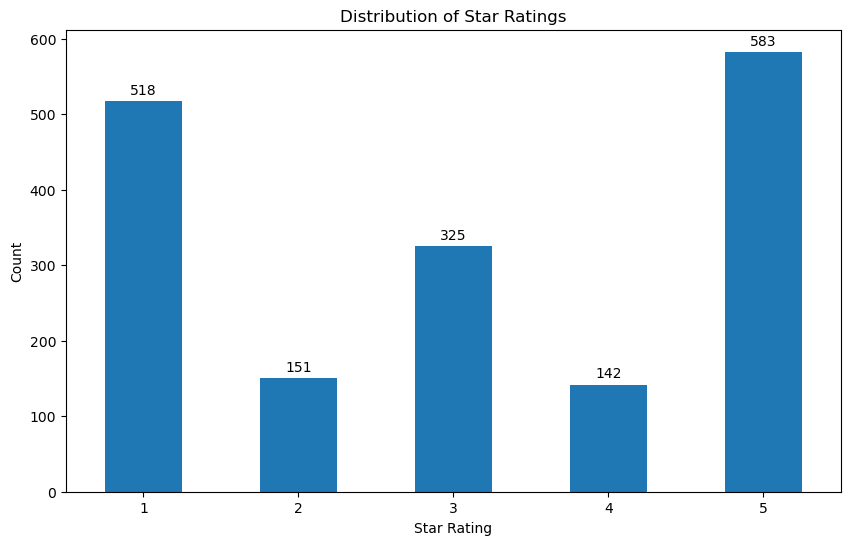

In [37]:
# Distribution of star ratings
star_rating_dist = ida_df['review_star_rating'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
ax = star_rating_dist.plot(kind='bar')
plt.title('Distribution of Star Ratings')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.xticks(rotation=0) # So we don't need to sprain our necks :)
for index, value in enumerate(star_rating_dist): # Adding the labels on top
    ax.text(index, value + 5, str(value), ha='center', va='bottom')
plt.show()

Based on this bar chart, we've got an uneven mix of reviews - for our EDA though, we'll probably cut these down to 3 buckets or segments.

## 4. Exploratory Data Analysis

In the EDA, we're going to work towards understanding the composition of the review text, and identifying and visualizing the key themes.

Firstly, as mentioned above, we'll reduce the number of categories to 3. We decided to group the ratings as below:

1. Excellent - reviews with 4 stars or higher
2. Average - reviews with 3 stars
3. Low - reviews with 2 stars or less

In [38]:
# Create a new dataframe for EDA
eda_df = all_reviews_english_unique
eda_df.head()

,review_id,review_title,review_comment,review_star_rating,reviewed_product_asin,review_year,review_country,comment_length
0,R3QVUB9DT90IEE,"Not great - weak audio, mic, cheapo build quality",You'll get what you pay for (or maybe even les...,2,B084X7Y51M,2023,Singapore,548
1,R1117V2OVYF9VG,Balanced sound,Well balanced sound and reasonable built quali...,5,B084X7Y51M,2023,Singapore,62
2,R10KG90XG89P1D,Quality ear piece at reasonable price.,Goods arrived the next day after order. Good q...,4,B084X7Y51M,2022,Singapore,59
4,RH1H14WGFEEWH,Great cheap earbuds,Exactly what you expect from this company and ...,5,B084X7Y51M,2024,the United States,60
6,R2FWKXPGXEIZFZ,Suitable for sleeping,The small profile of the earphones make it per...,5,B084X7Y51M,2024,the United States,100


##### Grouping the star reviews into categories

In [39]:
# Add a new column with the categorized ratings
eda_df['rating_category'] = eda_df['review_star_rating'].apply(categorize_rating)

# Display the updated DataFrame
print(eda_df[['review_star_rating', 'rating_category']].head())

   review_star_rating rating_category
0                   2             low
1                   5       excellent
2                   4         average
4                   5       excellent
6                   5       excellent


In [40]:
# Resetting the index
eda_df.reset_index(drop=True, inplace=True)
eda_df.head()

,review_id,review_title,review_comment,review_star_rating,reviewed_product_asin,review_year,review_country,comment_length,rating_category
0,R3QVUB9DT90IEE,"Not great - weak audio, mic, cheapo build quality",You'll get what you pay for (or maybe even les...,2,B084X7Y51M,2023,Singapore,548,low
1,R1117V2OVYF9VG,Balanced sound,Well balanced sound and reasonable built quali...,5,B084X7Y51M,2023,Singapore,62,excellent
2,R10KG90XG89P1D,Quality ear piece at reasonable price.,Goods arrived the next day after order. Good q...,4,B084X7Y51M,2022,Singapore,59,average
3,RH1H14WGFEEWH,Great cheap earbuds,Exactly what you expect from this company and ...,5,B084X7Y51M,2024,the United States,60,excellent
4,R2FWKXPGXEIZFZ,Suitable for sleeping,The small profile of the earphones make it per...,5,B084X7Y51M,2024,the United States,100,excellent


Let's check the distribution of the categories in the dataset

In [41]:
rating_cat_counts = eda_df['rating_category'].value_counts()
rating_cat_counts

low          669
excellent    583
average      467
Name: rating_category, dtype: int64

The category counts seem a bit skewed towards reviews with lower scores (low category).

##### Text Preprocessing 

This is an important step - so I'll highlight the objective and summarize the process.

The objective would be to convert the review text into individual pieces or tokens, making it easier for visualization and training models later.

For the process, the following steps will be applied in order:
1. **Lowercasing** - all words will be converted to lowercase
2. **Punctuation removal** - with regex parameters
3. **Word tokenization** - all words in a review will be converted into their own token or part
4. **Stop word removal** - removal of common words such as pronouns (i, we, they), articles (the, a, an) etc.
5. **Lemmatization** - converting the word token into its dictionary form e.g. sounding, sounds to sound
6. **Joining back** - the word tokens will be connected to a single space-delimited string for every review

I chose Lemmatization over Stemming as the latter although faster, leaves unusual, broken word stems, as compared to the former, which returns purer dictionary root words, although at a slower rate.

We've added the entire process to a single helper function **_preprocess_text_**. This will be applied to both review_title and review_comment columns

In [42]:
# Apply preprocessing to the review comments
eda_df['preprocessed_comment'] = eda_df['review_comment'].apply(preprocess_text)
eda_df['preprocessed_title'] = eda_df['review_title'].apply(preprocess_text)
eda_df.head()

,review_id,review_title,review_comment,review_star_rating,reviewed_product_asin,review_year,review_country,comment_length,rating_category,preprocessed_comment,preprocessed_title
0,R3QVUB9DT90IEE,"Not great - weak audio, mic, cheapo build quality",You'll get what you pay for (or maybe even les...,2,B084X7Y51M,2023,Singapore,548,low,youll get pay maybe even le definitely wouldnt...,great weak audio mic cheapo build quality
1,R1117V2OVYF9VG,Balanced sound,Well balanced sound and reasonable built quali...,5,B084X7Y51M,2023,Singapore,62,excellent,well balanced sound reasonable built quality p...,balanced sound
2,R10KG90XG89P1D,Quality ear piece at reasonable price.,Goods arrived the next day after order. Good q...,4,B084X7Y51M,2022,Singapore,59,average,good arrived next day order good quality sound,quality ear piece reasonable price
3,RH1H14WGFEEWH,Great cheap earbuds,Exactly what you expect from this company and ...,5,B084X7Y51M,2024,the United States,60,excellent,exactly expect company pretty durable,great cheap earbuds
4,R2FWKXPGXEIZFZ,Suitable for sleeping,The small profile of the earphones make it per...,5,B084X7Y51M,2024,the United States,100,excellent,small profile earphone make perfect like wear ...,suitable sleeping


In [43]:
# Combine the tokenized review and title into one column
eda_df['combined_text'] = eda_df['preprocessed_title'] + ' ' + eda_df['preprocessed_comment']
eda_df.head()

,review_id,review_title,review_comment,review_star_rating,reviewed_product_asin,review_year,review_country,comment_length,rating_category,preprocessed_comment,preprocessed_title,combined_text
0,R3QVUB9DT90IEE,"Not great - weak audio, mic, cheapo build quality",You'll get what you pay for (or maybe even les...,2,B084X7Y51M,2023,Singapore,548,low,youll get pay maybe even le definitely wouldnt...,great weak audio mic cheapo build quality,great weak audio mic cheapo build quality youl...
1,R1117V2OVYF9VG,Balanced sound,Well balanced sound and reasonable built quali...,5,B084X7Y51M,2023,Singapore,62,excellent,well balanced sound reasonable built quality p...,balanced sound,balanced sound well balanced sound reasonable ...
2,R10KG90XG89P1D,Quality ear piece at reasonable price.,Goods arrived the next day after order. Good q...,4,B084X7Y51M,2022,Singapore,59,average,good arrived next day order good quality sound,quality ear piece reasonable price,quality ear piece reasonable price good arrive...
3,RH1H14WGFEEWH,Great cheap earbuds,Exactly what you expect from this company and ...,5,B084X7Y51M,2024,the United States,60,excellent,exactly expect company pretty durable,great cheap earbuds,great cheap earbuds exactly expect company pre...
4,R2FWKXPGXEIZFZ,Suitable for sleeping,The small profile of the earphones make it per...,5,B084X7Y51M,2024,the United States,100,excellent,small profile earphone make perfect like wear ...,suitable sleeping,suitable sleeping small profile earphone make ...


In [44]:
file_path = "datasets/eda_df.csv"
eda_df.to_csv(file_path, index=False)
print(f"Updated data has been saved to {file_path}")

Updated data has been saved to datasets/eda_df.csv


In [45]:
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1719 entries, 0 to 1718
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   review_id              1719 non-null   object
 1   review_title           1719 non-null   object
 2   review_comment         1719 non-null   object
 3   review_star_rating     1719 non-null   int64 
 4   reviewed_product_asin  1719 non-null   object
 5   review_year            1719 non-null   int64 
 6   review_country         1719 non-null   object
 7   comment_length         1719 non-null   int64 
 8   rating_category        1719 non-null   object
 9   preprocessed_comment   1719 non-null   object
 10  preprocessed_title     1719 non-null   object
 11  combined_text          1719 non-null   object
dtypes: int64(3), object(9)
memory usage: 161.3+ KB


Now that we've processed the text into usable values, we can move into slightly more deeper visualization i.e. Word Clouds

##### Word Clouds

Word clouds are generally pretty to observe, but can be quite dense and obtuse. So, to keep the visual clean, we'll only create word clouds with a maximum of 20 terms or objects.
To complement the word cloud, we'll also show a bar chart with the top 20 terms in frequency across all reviews, reviews marked as excellent and reviews identied as poor / low.

Both charts will be generated with helper functions of their own.

###### All reviews

In [46]:
# Combine the text from each review and observed category into a single long string
all_reviews_text = ' '.join(eda_df['combined_text'])
excellent_reviews_text = ' '.join(eda_df[eda_df['rating_category'] == 'excellent']['combined_text'])
low_reviews_text = ' '.join(eda_df[eda_df['rating_category'] == 'low']['combined_text'])

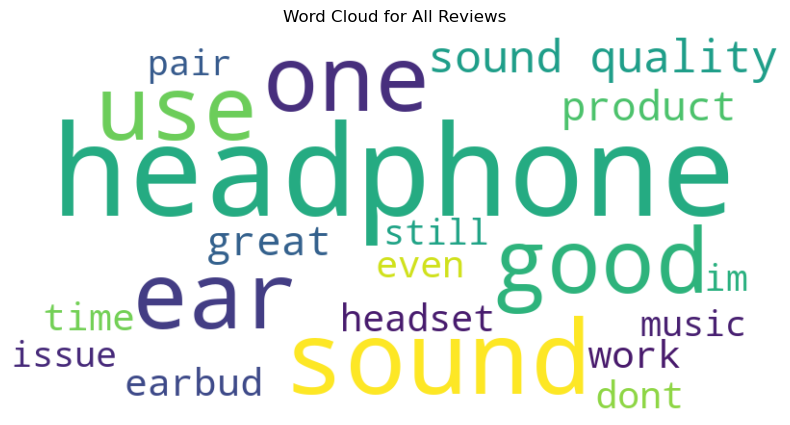

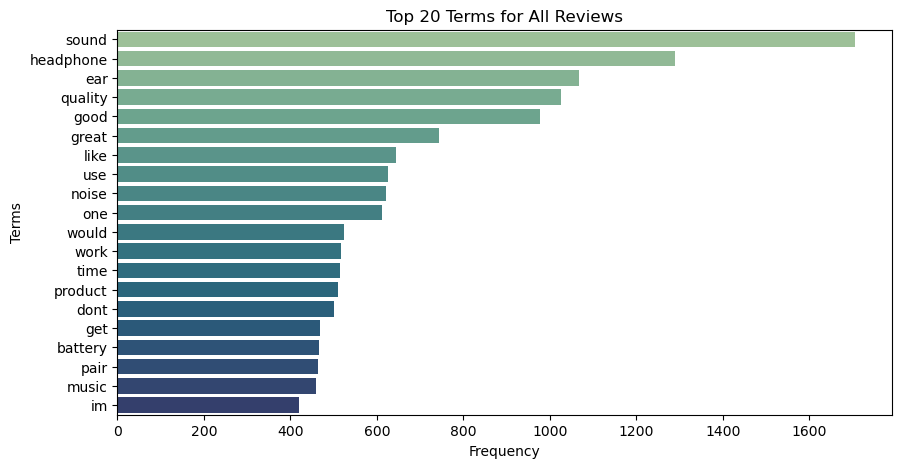

In [47]:
# Create word clouds and bar charts for the top 20 words from all reviews
create_wordcloud(all_reviews_text, 'Word Cloud for All Reviews', max_words=20)
create_barchart(all_reviews_text, 'Top 20 Terms for All Reviews', max_words=20)

###### "Excellent" reviews

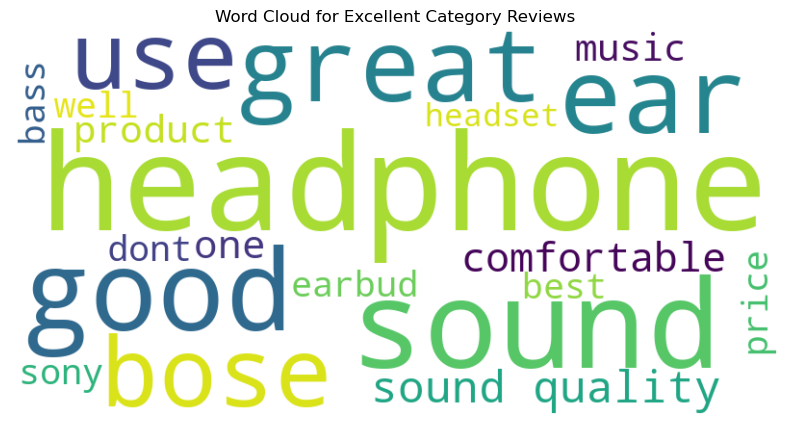

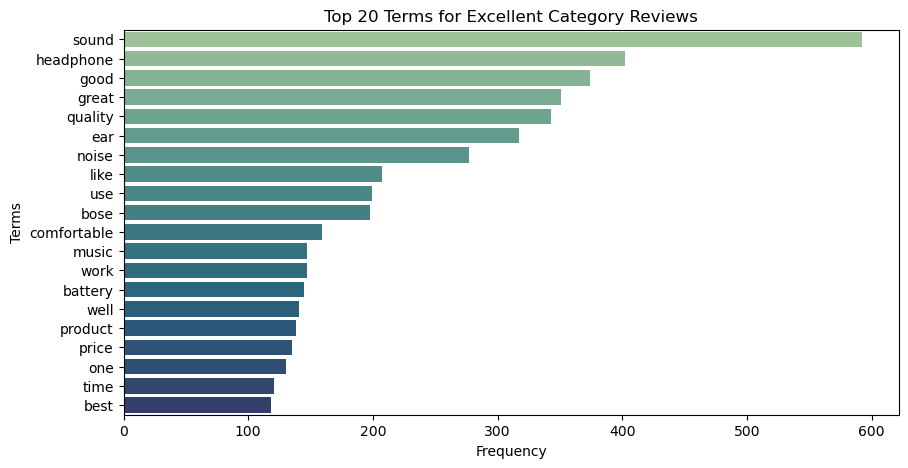

In [48]:
# Create word clouds and bar charts for the top 20 words from all reviews
create_wordcloud(excellent_reviews_text, 'Word Cloud for Excellent Category Reviews', max_words=20)
create_barchart(excellent_reviews_text, 'Top 20 Terms for Excellent Category Reviews', max_words=20)

###### "Low" reviews

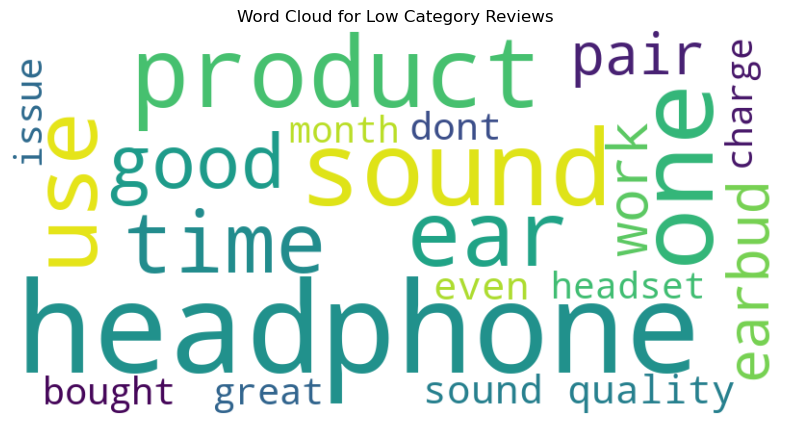

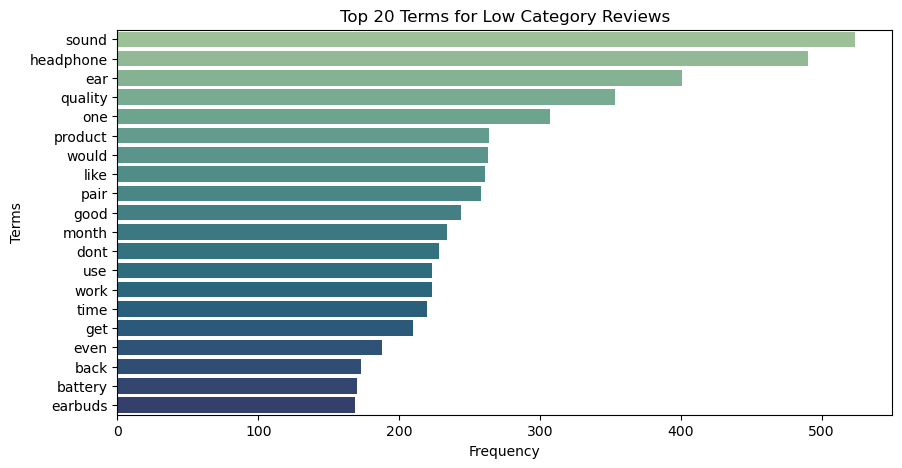

In [49]:
# Create word clouds and bar charts for the top 20 words from all reviews
create_wordcloud(low_reviews_text, 'Word Cloud for Low Category Reviews', max_words=20)
create_barchart(low_reviews_text, 'Top 20 Terms for Low Category Reviews', max_words=20)

Looking at all 6 graphs, we can note the following:
1. The top few terms across low, excellent and all reviews is very similar - sound, headphone, ear, quality, ear etc.
2. Under the Excellent category reviews, we see a few instances of brands being mentioned by name e.g. Sony, Bose etc.
3. Some generic features / terms show up towards the lower end of the graph e.g. battery, earbuds etc. for all reviews and the negative category. This might be due to the higher skew towards negative reviews mentioned earlier.

##### Bigrams and trigrams

Bigrams and trigrams are groups of 2 and 3 token words respectively - they can paint a better pattern than single word tokens.

The underlying feature is called **n-grams** - we will use a helper function - get_ngrams - to fetch and convert the text in combined_text to bigrams and trigrams.

In [50]:
# Get the most common bigrams (2-grams)
bigrams = get_ngrams(eda_df['combined_text'], 2)
print("Most common bigrams:")
print(bigrams.head(10))

Most common bigrams:
sound quality         515
battery life          211
noise cancelling      153
noise cancellation    139
ear bud               117
great sound            94
good sound             93
stopped working        88
sound good             81
bone conduction        75
dtype: int64


In [51]:
# Get the most common trigrams (3-grams)
trigrams = get_ngrams(eda_df['combined_text'], 3)
print("Most common trigrams:")
print(trigrams.head(10))

Most common trigrams:
sound quality good           39
sound quality great          32
bone conduction headphone    26
good sound quality           26
great sound quality          23
long battery life            16
sound quality really         16
battery life good            15
excellent sound quality      14
left ear bud                 14
dtype: int64


These are slightly more insightful than single word clouds - they add a bit more context around, and can be easily understood and interpreted.

Here, we can see that the most important qualities and aspects which come out in user reviews / feedback are:
1. Sound quality - users care about sound quality and fidelity, and will compliment a good product, and criticize a bad one
2. Battery life - this eludes to wireless models of audio devices, or ones which typically use portable batteries, with a finite life
3. Noise cancelling / reduction - a relatively specific feature
4. ear bud / left ear bud - focused on in-earphones, and the poor experience with some of them.


##### Aspects and Personas

To build on these aspects, I looked at a couple of resources online:
1. Head-fi.org - this is an audio enthusiast site, with reviews, buying guides and articles on headphones, earbuds etc.
2. wirecutter.com - similar to head-fi, but focused on all tech gadgets and platforms

I looked specifically at the buying guides, and the methods of testing used to review and evaluate products.

After a bit of research on these sites, and referencing the word cloud, we identified 5 specific Aspects and listed the top keywords from the reviews word clouds:
1. **Sound Quality** - 'sound', 'audio', 'bass', 'noise', 'quality'
2. **Comfort and Fit** - 'fit', 'comfort', 'wear', 'ear', 'head'
3. **Product Concerns** - 'issue', 'problem', 'broke', 'fail', 'defect'
4. **Battery Life** - 'battery', 'life', 'charge', 'performance'
5. **Purchase Experience** - 'purchase', 'buy', 'order', 'warranty', 'service'

Then, we cast these Aspects into discrete buyer Personas or User profiles to represent users who would typically buy and review such products. Again, for this personification, we relied on the research we had already done.

1. **Audiophile** - Sound Quality and Product Issues
2. **Lifestyle user** - Battery Life, Sound Quality
3. **Enthusiast** - Battery Life, Product Issues, Purchase Experience
4. **Professional** - Product Issues, Sound Quality, Comfort and Fit

The code below will do the following in 3 parts:

1. Define the Aspects and Personas as detailed above

2. A helper function will parse through each record in combined_text, and apply the Aspects to that record - by this, if a keyword from the list of Aspects is found, then the function will apply that Aspect to that row.

3. Finally, another helper function will then verify all the Aspects, and assign a Persona to that review - based on the above classification

In [52]:
# Define Aspects with keywords
aspects = {
    'Sound Quality': ['sound', 'audio', 'bass', 'noise', 'quality'],
    'Comfort and Fit': ['fit', 'comfort', 'wear', 'ear', 'head'],
    'Battery Life': ['battery', 'life', 'charge', 'performance'],
    'Product Issues': ['issue', 'problem', 'broke', 'fail', 'defect'],
    'Purchase Experience': ['purchase', 'buy', 'order', 'warranty', 'service']
}

# Define personas and their related topics
personas = {
    'Audiophile': ['Sound Quality', 'Product Issues'],
    'Frequent Traveler': ['Battery Life', 'Sound Quality'],
    'Enthusiast': ['Battery Life', 'Product Issues', 'Purchase Experience'],
    'Professional User': ['Product Issues', 'Sound Quality', 'Comfort and Fit']
}

In [53]:
# Apply the helper function to match aspect
eda_df['aspect'] = eda_df['preprocessed_comment'].apply(lambda x: match_aspect(x, aspects))
eda_df.head()

,review_id,review_title,review_comment,review_star_rating,reviewed_product_asin,review_year,review_country,comment_length,rating_category,preprocessed_comment,preprocessed_title,combined_text,aspect
0,R3QVUB9DT90IEE,"Not great - weak audio, mic, cheapo build quality",You'll get what you pay for (or maybe even les...,2,B084X7Y51M,2023,Singapore,548,low,youll get pay maybe even le definitely wouldnt...,great weak audio mic cheapo build quality,great weak audio mic cheapo build quality youl...,Sound Quality
1,R1117V2OVYF9VG,Balanced sound,Well balanced sound and reasonable built quali...,5,B084X7Y51M,2023,Singapore,62,excellent,well balanced sound reasonable built quality p...,balanced sound,balanced sound well balanced sound reasonable ...,Sound Quality
2,R10KG90XG89P1D,Quality ear piece at reasonable price.,Goods arrived the next day after order. Good q...,4,B084X7Y51M,2022,Singapore,59,average,good arrived next day order good quality sound,quality ear piece reasonable price,quality ear piece reasonable price good arrive...,Sound Quality
3,RH1H14WGFEEWH,Great cheap earbuds,Exactly what you expect from this company and ...,5,B084X7Y51M,2024,the United States,60,excellent,exactly expect company pretty durable,great cheap earbuds,great cheap earbuds exactly expect company pre...,Other
4,R2FWKXPGXEIZFZ,Suitable for sleeping,The small profile of the earphones make it per...,5,B084X7Y51M,2024,the United States,100,excellent,small profile earphone make perfect like wear ...,suitable sleeping,suitable sleeping small profile earphone make ...,Comfort and Fit


In [54]:
# Apply the helper function match_persona
eda_df['persona'] = eda_df['preprocessed_comment'].apply(lambda x: match_persona(x, personas, aspects))
eda_df.head()

,review_id,review_title,review_comment,review_star_rating,reviewed_product_asin,review_year,review_country,comment_length,rating_category,preprocessed_comment,preprocessed_title,combined_text,aspect,persona
0,R3QVUB9DT90IEE,"Not great - weak audio, mic, cheapo build quality",You'll get what you pay for (or maybe even les...,2,B084X7Y51M,2023,Singapore,548,low,youll get pay maybe even le definitely wouldnt...,great weak audio mic cheapo build quality,great weak audio mic cheapo build quality youl...,Sound Quality,Audiophile
1,R1117V2OVYF9VG,Balanced sound,Well balanced sound and reasonable built quali...,5,B084X7Y51M,2023,Singapore,62,excellent,well balanced sound reasonable built quality p...,balanced sound,balanced sound well balanced sound reasonable ...,Sound Quality,Audiophile
2,R10KG90XG89P1D,Quality ear piece at reasonable price.,Goods arrived the next day after order. Good q...,4,B084X7Y51M,2022,Singapore,59,average,good arrived next day order good quality sound,quality ear piece reasonable price,quality ear piece reasonable price good arrive...,Sound Quality,Audiophile
3,RH1H14WGFEEWH,Great cheap earbuds,Exactly what you expect from this company and ...,5,B084X7Y51M,2024,the United States,60,excellent,exactly expect company pretty durable,great cheap earbuds,great cheap earbuds exactly expect company pre...,Other,Other
4,R2FWKXPGXEIZFZ,Suitable for sleeping,The small profile of the earphones make it per...,5,B084X7Y51M,2024,the United States,100,excellent,small profile earphone make perfect like wear ...,suitable sleeping,suitable sleeping small profile earphone make ...,Comfort and Fit,Professional User


In [55]:
# Analyze the distribution of personas
persona_distribution = eda_df['persona'].value_counts()
print(persona_distribution)

Audiophile           1188
Other                 288
Professional User      84
Frequent Traveler      82
Enthusiast             77
Name: persona, dtype: int64


From the above table, we can confirm that most of the reviews are actually of type **Audiophile**

To display these in a visualization, we can use bar charts, and extract a stats card to use later for the slides.

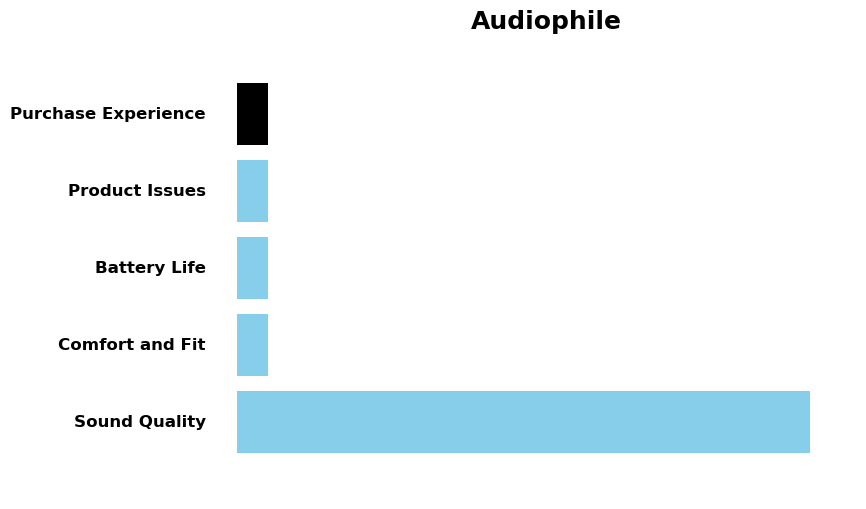

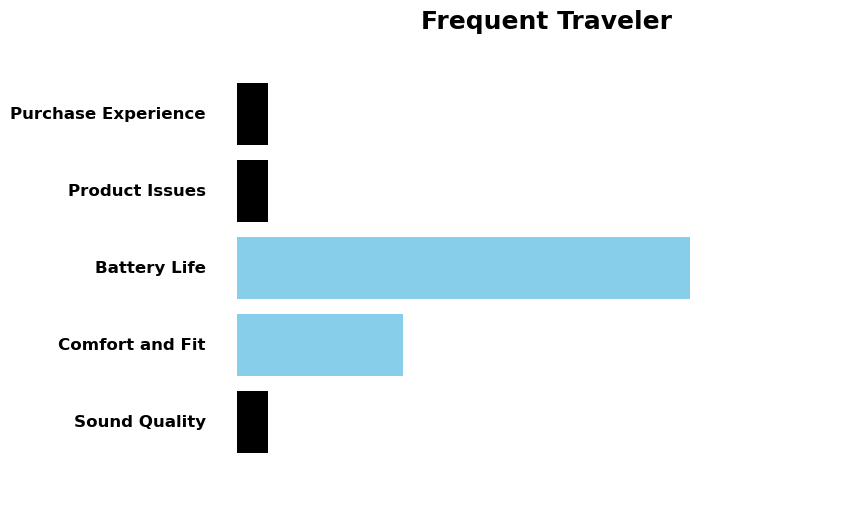

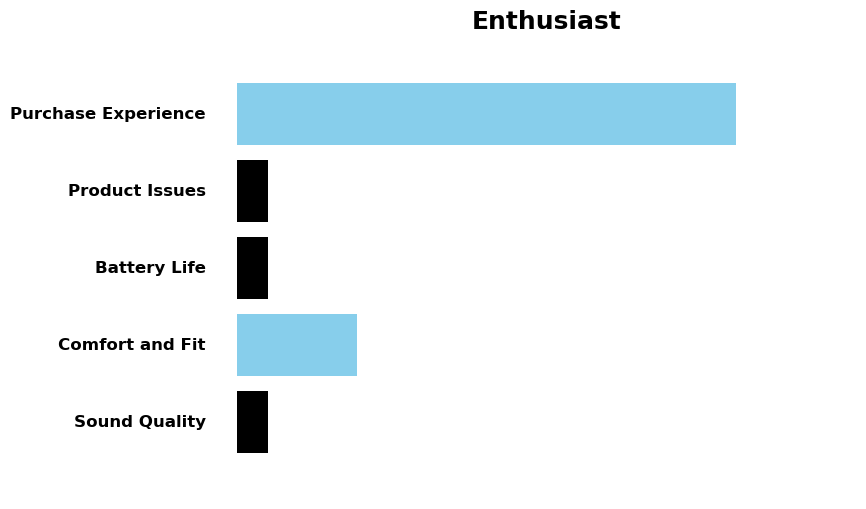

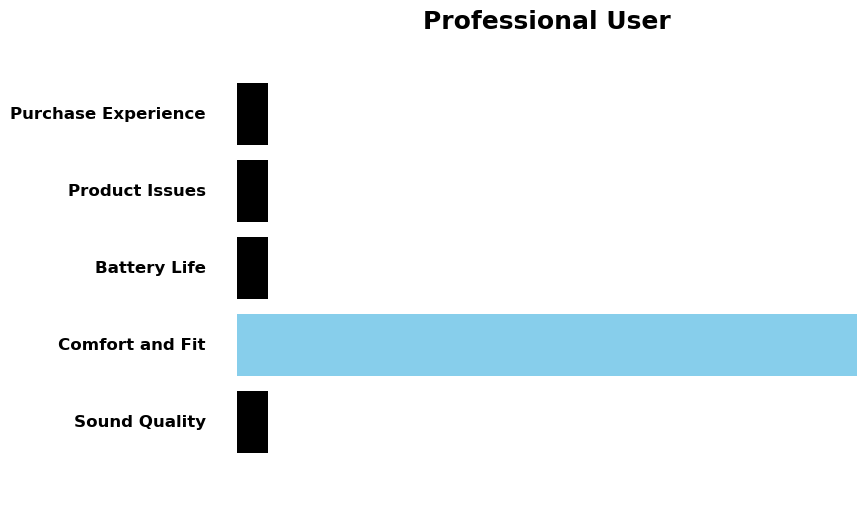

In [56]:
# Define a function to create a stats card with increased base bar height for 0% and a different color for these bars
def create_stats_card(persona, aspects):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(persona, fontsize=18, fontweight='bold')
    ax.set_xlim(0, 100)
    ax.set_ylim(0, len(aspects) + 1)
    ax.axis('off')
    
    persona_reviews = eda_df[eda_df['persona'] == persona]
    aspect_counts = Counter(persona_reviews['aspect'])
    
    for i, (aspect, keywords) in enumerate(aspects.items(), start=1):
        count = aspect_counts.get(aspect, 0)
        percentage = (count / persona_reviews.shape[0]) * 100 if persona_reviews.shape[0] > 0 else 0
        bar_height = max(percentage, 5)  # Ensure a minimal height for bars
        
        if percentage == 0:
            ax.barh(i, bar_height, color='black')
        else:
            ax.barh(i, bar_height, color='skyblue')
        
        ax.text(-5, i, aspect, va='center', ha='right', fontsize=12, fontweight='bold')
    
    return fig

# Create stats cards for each persona
for persona in personas.keys():
    fig = create_stats_card(persona, aspects)
    plt.show()
    fig.savefig(f'{persona}_stats_card.png', bbox_inches='tight', transparent=True)  # Save the figure

plt.close('all')  # Close all figures

That summarizes our EDA and visualizations section - next we move into NLP modelling and classification.

## 5. Modelling and Classification

For the data modelling section, we are going to run a sentiment analysis on the review text, with the target feature as the rating category (already grouped as excellent, average and low).

As the review text has been already preprocessed in the EDA dataset, we don't need to apply any tokenization or lemmatization etc.

We will however convert the rating_category into a numeric label - low = 0, average = 1 and excellent = 2

In [57]:
rating_category_mapping = {'low': 0, 'average': 1, 'excellent': 2}
# Use map() to quickly assign the numeric values
eda_df['rating_score'] = eda_df['rating_category'].map(rating_category_mapping)
eda_df.head()

,review_id,review_title,review_comment,review_star_rating,reviewed_product_asin,review_year,review_country,comment_length,rating_category,preprocessed_comment,preprocessed_title,combined_text,aspect,persona,rating_score
0,R3QVUB9DT90IEE,"Not great - weak audio, mic, cheapo build quality",You'll get what you pay for (or maybe even les...,2,B084X7Y51M,2023,Singapore,548,low,youll get pay maybe even le definitely wouldnt...,great weak audio mic cheapo build quality,great weak audio mic cheapo build quality youl...,Sound Quality,Audiophile,0
1,R1117V2OVYF9VG,Balanced sound,Well balanced sound and reasonable built quali...,5,B084X7Y51M,2023,Singapore,62,excellent,well balanced sound reasonable built quality p...,balanced sound,balanced sound well balanced sound reasonable ...,Sound Quality,Audiophile,2
2,R10KG90XG89P1D,Quality ear piece at reasonable price.,Goods arrived the next day after order. Good q...,4,B084X7Y51M,2022,Singapore,59,average,good arrived next day order good quality sound,quality ear piece reasonable price,quality ear piece reasonable price good arrive...,Sound Quality,Audiophile,1
3,RH1H14WGFEEWH,Great cheap earbuds,Exactly what you expect from this company and ...,5,B084X7Y51M,2024,the United States,60,excellent,exactly expect company pretty durable,great cheap earbuds,great cheap earbuds exactly expect company pre...,Other,Other,2
4,R2FWKXPGXEIZFZ,Suitable for sleeping,The small profile of the earphones make it per...,5,B084X7Y51M,2024,the United States,100,excellent,small profile earphone make perfect like wear ...,suitable sleeping,suitable sleeping small profile earphone make ...,Comfort and Fit,Professional User,2


Next, we'll use run a standard train-test-split with the test sample at 25%. 
Additionally, we'll use stratification to maintain the ratio of the rating categories for both sets of data.

The target is rating_score, while the input feature is preprocessed_review.

##### Train-test-split

In [58]:
target = eda_df['rating_score']
features = eda_df['preprocessed_comment']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    target, 
                                                    test_size=0.25, 
                                                    stratify=target,
                                                    random_state=42)
# Verify the stratification
print("Training set class distribution:")
print(y_train.value_counts(normalize=True))
print("\nTesting set class distribution:")
print(y_test.value_counts(normalize=True))

Training set class distribution:
0    0.389449
2    0.339022
1    0.271528
Name: rating_score, dtype: float64

Testing set class distribution:
0    0.388372
2    0.339535
1    0.272093
Name: rating_score, dtype: float64


##### Model selection

We will run both 'simple' as well as 'advanced' models - the distinction is based on their relative explanability:

Simple Models:
- Naive Bayes
- Decision Tree
- Random Forests

Advanced Models:
- Support Vector Machines
- Gradient Boosting
- XGB

As instructed, we have to use Naive Bayes for this project to classify the text.
We will use Naive Bayes, and compare between TF-IDF and Word2Vec vectorizers to establish a baseline model to start with.

As we are dealing with word vectors and frequencies in TF-IDF, we will rely on MultinomialNB as the primary classifier.

Whereas with Word2Vec, the tokens are converted into distance vectors which are continuous, we will use GaussianNB.

In [59]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train and evaluate Naive Bayes classifier with TF-IDF features
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = nb_tfidf.predict(X_test_tfidf)

print("TF-IDF Naive Bayes Classifier Report:")
print(classification_report(y_test, y_pred_tfidf))

TF-IDF Naive Bayes Classifier Report:
              precision    recall  f1-score   support

           0       0.54      0.95      0.69       167
           1       0.43      0.03      0.05       117
           2       0.73      0.66      0.70       146

    accuracy                           0.60       430
   macro avg       0.57      0.55      0.48       430
weighted avg       0.58      0.60      0.52       430



In [60]:
# Word2Vec Vectorization
X_train_tokens = [comment.split() for comment in X_train]
X_test_tokens = [comment.split() for comment in X_test]
word2vec_model = Word2Vec(sentences=X_train_tokens, 
                          vector_size=100, 
                          window=5, 
                          min_count=1, 
                          workers=4)

def get_word2vec_vector(comment_tokens, model):
    word_vectors = [model.wv[word] for word in comment_tokens if word in model.wv]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(100)

X_train_word2vec = np.array([get_word2vec_vector(comment, word2vec_model) for comment in X_train_tokens])
X_test_word2vec = np.array([get_word2vec_vector(comment, word2vec_model) for comment in X_test_tokens])

# Train and evaluate Naive Bayes classifier with Word2Vec features
nb_word2vec = GaussianNB()
nb_word2vec.fit(X_train_word2vec, y_train)
y_pred_word2vec = nb_word2vec.predict(X_test_word2vec)

print("Word2Vec Naive Bayes Classifier Report:")
print(classification_report(y_test, y_pred_word2vec))

Word2Vec Naive Bayes Classifier Report:
              precision    recall  f1-score   support

           0       0.39      0.11      0.17       167
           1       0.29      0.69      0.41       117
           2       0.51      0.37      0.43       146

    accuracy                           0.36       430
   macro avg       0.40      0.39      0.34       430
weighted avg       0.40      0.36      0.32       430



Based on the above reports, it's clear that the TF-IDF classifier performs much better (accuracy = 0.6) as compared to the Word2Vec model.

We'll establish the baseline then as Naive Bayes with TF-IDF on the preprocessed_review column.

##### Baseline model

In [61]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Initialize the Multinomial Naive Bayes classifier
nb_tfidf = MultinomialNB()

# Train and evaluate the Naive Bayes classifier with TF-IDF features
nb_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = nb_tfidf.predict(X_test_tfidf)

print("TF-IDF Naive Bayes Classifier Report:")
print(classification_report(y_test, y_pred_tfidf, target_names=['low', 'average', 'excellent']))

TF-IDF Naive Bayes Classifier Report:
              precision    recall  f1-score   support

         low       0.54      0.95      0.69       167
     average       0.43      0.03      0.05       117
   excellent       0.73      0.66      0.70       146

    accuracy                           0.60       430
   macro avg       0.57      0.55      0.48       430
weighted avg       0.58      0.60      0.52       430



##### Naive Bayes with combined_text as feature

Since we already have a column combining review title and text, we can try and see if this combination gets us a better result.

In [62]:
new_features = eda_df['combined_text'] # target remains the same
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(new_features, 
                                                    target, 
                                                    test_size=0.25, 
                                                    stratify=target,
                                                    random_state=42)
# Verify the stratification
print("Training set class distribution:")
print(y_train.value_counts(normalize=True))
print("\nTesting set class distribution:")
print(y_test.value_counts(normalize=True))

Training set class distribution:
0    0.389449
2    0.339022
1    0.271528
Name: rating_score, dtype: float64

Testing set class distribution:
0    0.388372
2    0.339535
1    0.272093
Name: rating_score, dtype: float64


Next, we apply Naive Bayes with TF-IDF again

In [63]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Initialize the Multinomial Naive Bayes classifier
nb_tfidf = MultinomialNB()

# Train and evaluate the Naive Bayes classifier with TF-IDF features
nb_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = nb_tfidf.predict(X_test_tfidf)

print("TF-IDF Naive Bayes Classifier Report:")
print(classification_report(y_test, y_pred_tfidf, target_names=['low', 'average', 'excellent']))

TF-IDF Naive Bayes Classifier Report:
              precision    recall  f1-score   support

         low       0.57      0.96      0.72       167
     average       0.57      0.03      0.06       117
   excellent       0.75      0.73      0.74       146

    accuracy                           0.63       430
   macro avg       0.63      0.57      0.51       430
weighted avg       0.63      0.63      0.55       430



We can see a slight increase in overall accuracy, from 0.60 to 0.63. Moving forward, we'll stick to using combined_text for the models ahead.

##### Naive Bayes with TF-IDF and n-grams (bi-grams and tri-grams)

As we've used only individual word tokens, we can see if using bi-grams and tri-grams helps to improve the result.

In [64]:
# Create n-gram features using TF-IDF vectorizer
ngram_vectorizer = TfidfVectorizer(ngram_range=(1, 3))  # Using unigrams, bigrams and trigrams
X_train_ngram = ngram_vectorizer.fit_transform(X_train)
X_test_ngram = ngram_vectorizer.transform(X_test)

# Display the shape of the n-gram features
print("N-gram TF-IDF shape:", X_train_ngram.shape, X_test_ngram.shape)

N-gram TF-IDF shape: (1289, 130589) (430, 130589)


In [65]:
# Train Naive Bayes classifier with n-gram TF-IDF features
nb_ngram = MultinomialNB()
nb_ngram.fit(X_train_ngram, y_train)
y_pred_ngram = nb_ngram.predict(X_test_ngram)

print("N-gram TF-IDF Naive Bayes Classifier Report:")
print(classification_report(y_test, y_pred_ngram, target_names=['low', 'average', 'excellent']))

N-gram TF-IDF Naive Bayes Classifier Report:
              precision    recall  f1-score   support

         low       0.53      0.99      0.69       167
     average       0.00      0.00      0.00       117
   excellent       0.80      0.64      0.71       146

    accuracy                           0.60       430
   macro avg       0.44      0.55      0.47       430
weighted avg       0.48      0.60      0.51       430



With the n-gram vectorizer, we actually see a drop in accuracy, and the Average category doesn't register any scores on this model. So, the best-performing model so far is Naive Bayes on combined_text.

##### Decision Tree Classifier

The Decision Tree classifier is a simple model, and easily explainable. To get the most optimal params, we'll directly use a GridSearch cross-validation to get the best params possible.

In [66]:
# Initialize the Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Define the parameter grid
dt_params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=dt_classifier, 
                           param_grid=dt_params, cv=5, 
                           scoring='accuracy', n_jobs=-1)

In [67]:
# Fit GridSearchCV
grid_search.fit(X_train_tfidf, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters found: ", best_params)
print("Best cross-validation accuracy: {:.3f}".format(best_score))

/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/anilgangolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

Best parameters found:  {'criterion': 'gini', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 2, 'splitter': 'random'}
Best cross-validation accuracy: 0.558


In [68]:
# Train the Decision Tree classifier with the best parameters
best_dt_classifier = grid_search.best_estimator_
best_dt_classifier.fit(X_train_tfidf, y_train)
y_pred_tfidf = best_dt_classifier.predict(X_test_tfidf)

print("TF-IDF Decision Tree Classifier Report:")
print(classification_report(y_test, y_pred_tfidf, target_names=['low', 'average', 'excellent']))

TF-IDF Decision Tree Classifier Report:
              precision    recall  f1-score   support

         low       0.63      0.74      0.68       167
     average       0.40      0.25      0.31       117
   excellent       0.59      0.65      0.62       146

    accuracy                           0.57       430
   macro avg       0.54      0.55      0.53       430
weighted avg       0.55      0.57      0.56       430



With Decision Trees, we find that the accuracy (0.57) drops further below the baseline model we established.

##### Random Forests

Random Forest is an ensembling classifier, built on Decision Trees. We'll check this to see if ensembling helps increase accuracy.

In [69]:
# Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42) # Using 100 estimators for the ensemble
rf_classifier.fit(X_train_tfidf, y_train)
y_pred_rf = rf_classifier.predict(X_test_tfidf)

print("Random Forest Classifier Report:")
print(classification_report(y_test, y_pred_rf, target_names=['low', 'average', 'excellent']))

Random Forest Classifier Report:
              precision    recall  f1-score   support

         low       0.66      0.81      0.73       167
     average       0.69      0.17      0.27       117
   excellent       0.62      0.84      0.71       146

    accuracy                           0.64       430
   macro avg       0.66      0.60      0.57       430
weighted avg       0.65      0.64      0.60       430



With Random Forests, we only see 1% increase in accuracy to 0.64

### Advanced Models

The models below are considered advanced due to their 'black-box' nature, but they may perform better than the previous ones

##### Support Vector Machines

We'll try out Support Vector Classification with a linear kernel for simplicity

In [70]:
# Support Vector Machine Classifier
svm_classifier = SVC(kernel='linear', random_state=42)  # Using a linear kernel for simplicity
svm_classifier.fit(X_train_tfidf, y_train)
y_pred_svm = svm_classifier.predict(X_test_tfidf)

print("Support Vector Machine Classifier Report:")
print(classification_report(y_test, y_pred_svm))

Support Vector Machine Classifier Report:
              precision    recall  f1-score   support

           0       0.69      0.83      0.75       167
           1       0.57      0.35      0.43       117
           2       0.72      0.79      0.75       146

    accuracy                           0.68       430
   macro avg       0.66      0.65      0.65       430
weighted avg       0.67      0.68      0.67       430



The SVM classifier gives our best result so far with an accuracy of 0.68

##### Gradient Boosting

Here we'll use the simple vanilla boosting classifier from sklearn

In [71]:
# Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_classifier.fit(X_train_tfidf, y_train)
y_pred_gb = gb_classifier.predict(X_test_tfidf)

print("Gradient Boosting Classifier Report:")
print(classification_report(y_test, y_pred_gb))

Gradient Boosting Classifier Report:
              precision    recall  f1-score   support

           0       0.69      0.80      0.74       167
           1       0.52      0.31      0.39       117
           2       0.65      0.75      0.69       146

    accuracy                           0.65       430
   macro avg       0.62      0.62      0.61       430
weighted avg       0.63      0.65      0.63       430



We get an accuracy score of 0.65 - a bit better than the simpler models, but less than SVM above.

##### XGBoost Classifier

This is our last model to test... which fails everytime I run. The code is commented out.

In [72]:
# # XGBoost Classifier 
# xgb_classifier = xgb.XGBClassifier(n_estimators=100, random_state=42)
# xgb_classifier.fit(X_train_tfidf, y_train)
# y_pred_xgb = xgb_classifier.predict(X_test_tfidf)

# print("XGBoost Classifier Report:")
# print(classification_report(y_test, y_pred_xgb))

## 6. Conclusions and Next Steps

Based on the tests above, we can see that the best model in terms of accuracy was the SVM Classifier with an accuracy score of 0.68. See table below for more details:

|Model Name|Accuracy Score|Type|Vectorizer|Notes|
|-|-|-|-|-|
|Naive Bayes|0.60|Simple|TF-IDF|Baseline model using only review_comment text|
|Naive Bayes|0.37|Simple||Word2Vec|Worst performer|
|Naive Bayes|0.63|Simple|TF-IDF|Combines review title and review comment|
|Decision Trees|0.57|Simple|TF-IDF|Worse than baseline|
|Random Forests|0.64|Simple|TF-IDF|Best among the simple models|
|**Support Vector Machines**|**0.68**|**Advanced**|**TF-IDF**|**Best of all models tested**|
|Gradient Boosting|0.65|Advanced|TF-IDF||
|XGBoost|-|Advanced|TF-IDF|Couldn't test this due to Kernel issues..|

Also, we identified several key categories (Aspects) and built on them to obtain a list of typical Buyer Personas to help the client (Shure) to identify their user demographic.

**Aspects**

|Aspect|Key words|
|-|-|
|Sound Quality|'sound', 'audio', 'bass', 'noise', 'quality'|
|Comfort and Fit|'fit', 'comfort', 'wear', 'ear', 'head'|
|Battery Life|'battery', 'life', 'charge', 'performance'|
|Product Issues|'issue', 'problem', 'broke', 'fail', 'defect'|
|Purchase Experience|purchase', 'buy', 'order', 'warranty', 'service'|

**Personas**

|Persona|Aspects|
|-|-|
|Audiophile|Sound Quality, Product Issues|
|Frequent Traveler|Battery Life, Sound Quality|
|Enthusiast|Battery Life, Product Issues, Purchase Experience|
|Professional|Product Issues, Sound Quality, Comfort and Fit|


#### Next Steps

For the analysis -

1. We can identify and scrape more reviews from local e-commerce sites such as Lazada, Shopee etc.
2. We can look into more advanced modeling and fine-tuning with GridSearchCV etc.
3. Deploy other gradient-boosting models such as Catboost, LightGBM in place of XGB

For the client, Shure, -

1. Focus on the Aspects (category themes) and the Buyer Personas to introduce products based on these archetypes
2. Conduct more user research including both review analysis, as well as other forms of feedback gathering such as surveys, competitor research etc.